# Takehome Challenge: Ultimate Tech Inc.

Ultimate Technologies Inc. is an American worldwide online transportation network company that has disrupted the taxi and logistics industry and is a prestigious companies to work at. This challenge contains three parts: 
1. Part 1: User Demand Analysis 
2. Part 2: Experiment Design 
3. Part 3: User Retention 

## Part 1: Exploratory Data Analysis on User Demand

### Read User Login Timestamps (JSON file)

In [2]:
login_df = pd.read_json('logins.json')

In [3]:
login_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
login_df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [5]:
login_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


### Aggregation by 15min Interval

In [6]:
demand_df = login_df.resample('15T',on='login_time').apply('count')
demand_df.index.name = 'time'
demand_df.columns = ['counts']
demand_df.reset_index(inplace=True)
func_add_datepart(demand_df, 'time', drop=False, attr = ['Dayofweek','Hour'])
demand_df.head()

,time,counts,timeDayofweek,timeHour,timeElapsed
0,1970-01-01 20:00:00,2,3,20,72000
1,1970-01-01 20:15:00,6,3,20,72900
2,1970-01-01 20:30:00,9,3,20,73800
3,1970-01-01 20:45:00,7,3,20,74700
4,1970-01-01 21:00:00,1,3,21,75600


C:\Users\zb\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


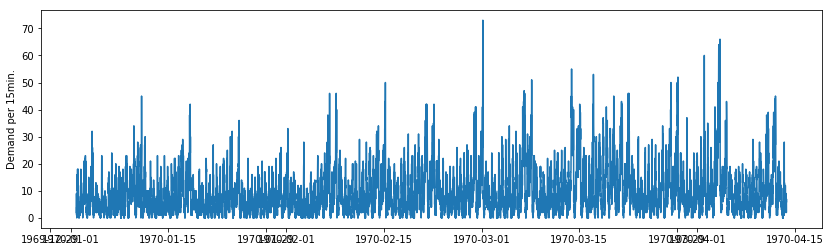

In [8]:
# time series plot of demand
plt.figure(figsize=(14,4))
plt.plot(demand_df.time, demand_df.counts)
plt.ylabel('Demand per 15min.')
plt.show()

### Demand Cycle Analysis

#### Seasonal Decomposition: Assume Weekly Pattern

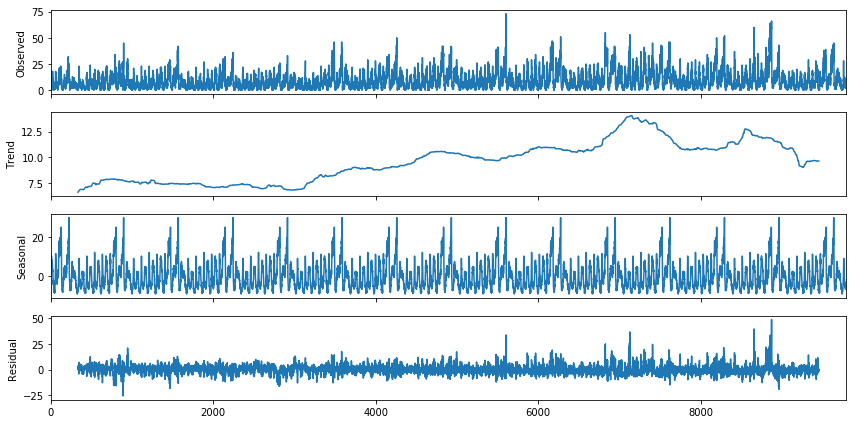

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams["figure.figsize"] = (12,6)
# 1 week = 7 days x 24 hours/day * 4_15min/hour
result = seasonal_decompose(demand_df['counts'], model='additive', freq=4*24*7)
result.plot()
plt.show()

#### Weekly Demand Trend

In [10]:
demand_weekly = demand_df[['counts','timeDayofweek']].groupby('timeDayofweek').agg(['mean','std'])
demand_weekly.columns = demand_weekly.columns.get_level_values(1)
demand_weekly.head()

,mean,std
timeDayofweek,,
0,6.213380,5.029465
1,6.895833,6.264071
2,7.692708,6.567372
3,8.794118,7.058483
4,10.561111,8.172082


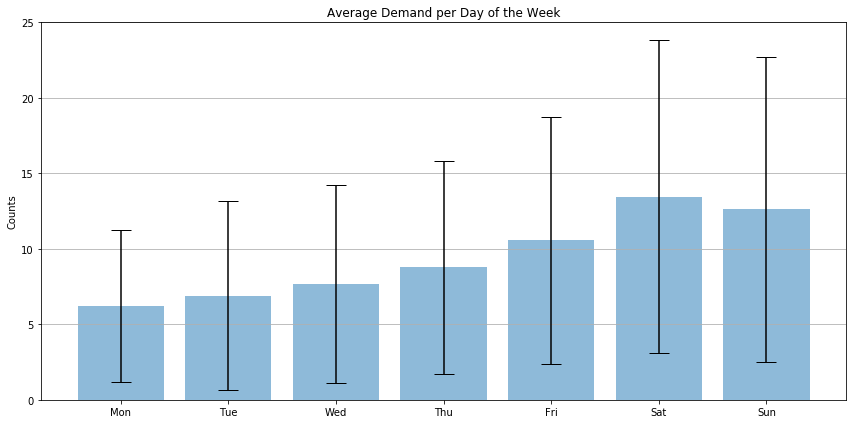

In [11]:
fig, ax = plt.subplots()
ax.bar(demand_weekly.index.values, demand_weekly['mean'], yerr=demand_weekly['std'], 
       align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Counts')
ax.set_xticklabels(['','Mon','Tue','Wed','Thu','Fri','Sat','Sun',''])
ax.set_title('Average Demand per Day of the Week')
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

#### Hourly Demand Trend

In [12]:
demand_hourly = demand_df[['counts','timeHour']].groupby('timeHour').agg(['mean','std'])
demand_hourly.columns = demand_hourly.columns.get_level_values(1)
demand_hourly.head()

,mean,std
timeHour,,
0,14.688725,7.548934
1,15.482843,9.845474
2,14.215686,10.538221
3,11.840686,11.317904
4,12.338235,14.149893


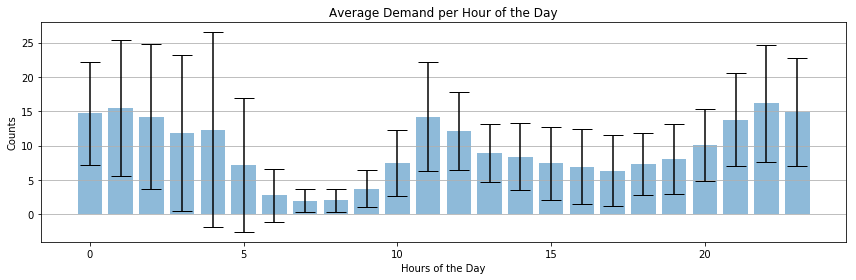

In [13]:
fig, ax = plt.subplots(figsize=(12,4))
ax.bar(demand_hourly.index.values, demand_hourly['mean'], yerr=demand_hourly['std'], 
       align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xlabel('Hours of the Day')
ax.set_ylabel('Counts')
# ax.set_xticklabels(['','Mon','Tue','Wed','Thu','Fri','Sat','Sun',''])
ax.set_title('Average Demand per Hour of the Day')
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

### Discussion on Demand Analysis 

Based on the above analysis and observations, two major demand cycles are identified: 
1. A weekly cycle: with the demand gradually build up pver the week, peaking during the weekends. 
2. A daily cycle: with two peaks around middle of the day and around midnight. 

Besides, based on the decomposition, there is also a general increasing trend over time.  

## Part 2: Experiment and Metrics Design (A/B Testing)

The key information regarding the problem is summarized again here: Gotham and Metropolis are two neighbouring cities,
* On weekdays: Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day.
* On weekends: there is reasonable activity in both cities. 
* There is a toll bridge between the two cities causing driver partners to tend to be exclusive to each city.

Context: The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

**Q1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?**
- Answer: I would choose the key measure of success to be there is significant increase in the percentage of driver exchange between two cities during weekend. Due to the distinct different cicadian rhythms, it is less effective to perform experients on weekdays due to the lack of activities. 


**Q2: Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:**
    1. how you will implement the experiment
    2. what statistical test(s) you will conduct to verify the significance of the observation
    3. how you would interpret the results and provide recommendations to the city operations team along with any caveats.
    
- Answer: 
    1. In order to implement the experiment, we need to perform A/B Testing by first collect control and treatment group datasets and then use two-sample hypothesis testing to test the significance between these two groups. To conduct the A/B testing, the following procedures need to be conducted: 
        - Before implementing the reimbursement, track the driver's trajectory continuously for at least 1 week. The key feature to be measured can be the number of times a driver switch between two cities per day. This will form the "control group". 
        - The drivers will them be informed about the reimbursement toll policy, and their trajectory will be tracked for the same length of period as the control group. Similar feature can be extracted during this period. 
    2. Two-sample hypothesis testing can be performed based on the control and treatment group datasets. For example, we can compare the average number of switches between two cities with
        - H0: control = treatment
        - Ha: control < treatment
        - Then a two-sample t-test can be utilized to quantify the statistical significance, and check if the reimbursement policy will lead to signicantly higher exchange of drivers among the two cities.  
    3. If there is indeed a statistical significant advantage of the reimbursement policy (i.e. treatment > control), we need to proceed further with cost analysis by comparing the toll revenues before and after implementing the policy. Although the toll charge per trip is reduced, it might still yield a higher gain if the increased traffic quantify can boost the total revenue. In such case, we would encourage the policy. 

## Part 3: Rider Retention Prediction

In [2]:
%load_ext autoreload
%autoreload 2

from udf import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import re
import pickle
import seaborn as sns

from tpot import TPOTClassifier

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#%load_ext pycodestyle_magic

%load_ext watermark
%watermark -a "by Zhao Bing" -d -t -v -p numpy,pandas,sklearn,xgboost,matplotlib,tpot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
by Zhao Bing 2019-05-15 22:25:20 

CPython 3.6.8
IPython 7.2.0

numpy 1.15.2
pandas 0.24.1
sklearn 0.20.1
xgboost 0.81
matplotlib 3.0.2
tpot 0.9.5


In [3]:
import json
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
df0 = pd.DataFrame(data)

In [4]:
df0.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


### Data Type Checking and Conversion

In [7]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


#### Convert DateTime Features

In [5]:
df0['last_trip_date'] = pd.to_datetime(df0['last_trip_date'],format='%Y-%m-%d')
df0['signup_date'] = pd.to_datetime(df0['signup_date'],format='%Y-%m-%d')

#### Boolean to Integer

In [6]:
df0['ultimate_black_user'] = df0['ultimate_black_user']*1

In [19]:
df0.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,1,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,0,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,0,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,1,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,0,82.4


In [20]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int32
weekday_pct               50000 non-null float64
dtypes: datetime64[ns](2), float64(6), int32(1), int64(1), object(2)
memory usage: 4.4+ MB


### Labeling of Active User

A user is considered "active" if they took a trop in the preceding 30 days. However, in this dataset, we only have the `signup_date` and `last_trip_date`. Thus, it might be inconclusive for some users if their status within the 30 days of the 6th month is unknown. In this section, the status of users is labeled according to the following rules: 
* If `last_trip_date` <= `signup_date` + 6mth - 30days, user is inactive (denoted as 0);
* If `signup_date` + 6mth - 30days < `last_trip_date` <= `signup_date` + 6mth, user is active (denoted as 1);
* If `last_trip_date` > `signup_date` + 6mth, user's status is unkown (in this dataset, there is no such case);

In [7]:
df0['active'] = 0
flag1 = (df0['last_trip_date'] >= (df0['signup_date'] + pd.Timedelta(6,'M') - pd.Timedelta(30,'D'))) & (df0['last_trip_date'] <= (df0['signup_date'] + pd.Timedelta(6,'M')))
df0.loc[flag1,'active'] = 1
df0['active'].value_counts()

0    38806
1    11194
Name: active, dtype: int64

Remove signup date and last trip date, as they are used for labeling. Including such features will cause data leakage.

In [8]:
# remove signup data and last trip date, as they are used for labeling 
# including such features will cause data leakage
df0.drop(columns=['signup_date','last_trip_date'], inplace=True)

In [9]:
cols_dict, cols_df = func_df_col_names_by_type(df0.drop(columns=['active']), flag_print = False)

In [24]:
cols_dict

{'cols_number': ['avg_dist',
  'avg_rating_by_driver',
  'avg_rating_of_driver',
  'avg_surge',
  'surge_pct',
  'trips_in_first_30_days',
  'ultimate_black_user',
  'weekday_pct'],
 'cols_string': ['city', 'phone'],
 'cols_binary': ['ultimate_black_user'],
 'cols_number_exclude_binary': ['avg_dist',
  'avg_rating_by_driver',
  'avg_rating_of_driver',
  'avg_surge',
  'surge_pct',
  'trips_in_first_30_days',
  'weekday_pct'],
 'cols_string_include_binary': ['city', 'phone', 'ultimate_black_user'],
 'cols_datetime': [],
 'cols_timedelta': [],
 'cols_category': [],
 'cols_others': []}

## Exploratory Data Analysis

In this part, the following exploratory data analysis is done: 
* explore the basic stats including, mean, min, max, quantils, and percentage of missing values for each column 
* use Box Plots for identifying any potential outliers (numerical features only)
* plot the disitributions factored by label ('adopted_user')
* perform simply correlation analysis and visualization to examine the correlation among features and label. 

### Summary of Statistics
It is observed that 
* There are missing values in some field, but generally with low percentages;


In [65]:
# summarize: statistics | missing value | data type 
df0_stat = pd.concat([pd.DataFrame(df0.dtypes,columns=['type']), func_df_describe_all(df0)], axis=1)
func_df_display_all(df0_stat)

,type,count,unique,top,freq,mean,std,min,25%,50%,75%,max,miss_perc
avg_dist,float64,50000,NaN,NaN,NaN,5.79683,5.70736,0,2.42,3.88,6.94,160.96,0.000
avg_rating_by_driver,float64,49799,NaN,NaN,NaN,4.77816,0.446652,1,4.7,5,5,5,0.402
avg_rating_of_driver,float64,41878,NaN,NaN,NaN,4.60156,0.617338,1,4.3,4.9,5,5,16.244
avg_surge,float64,50000,NaN,NaN,NaN,1.07476,0.222336,1,1,1,1.05,8,0.000
city,object,50000,3,Winterfell,23336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
phone,object,49604,2,iPhone,34582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.792
surge_pct,float64,50000,NaN,NaN,NaN,8.84954,19.9588,0,0,0,8.6,100,0.000
trips_in_first_30_days,int64,50000,NaN,NaN,NaN,2.2782,3.79268,0,0,1,3,125,0.000
ultimate_black_user,int32,50000,NaN,NaN,NaN,0.37708,0.48466,0,0,0,1,1,0.000
weekday_pct,float64,50000,NaN,NaN,NaN,60.9261,37.0815,0,33.3,66.7,100,100,0.000


### Box Plots (Check Outliers for Numerical Features)

There are no obvious outliers in the numerical features. However, the boxplots suggest that most of the numerical features are not normally distributed and highly skewed. 

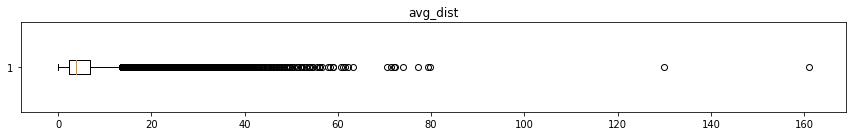

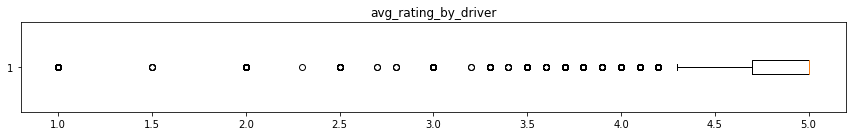

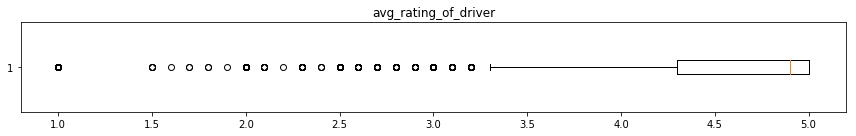

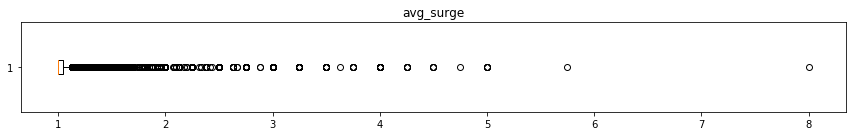

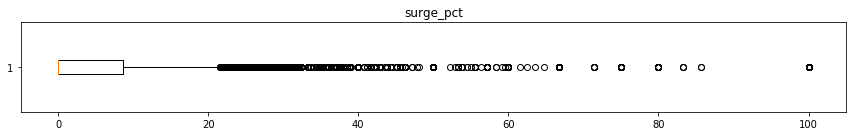

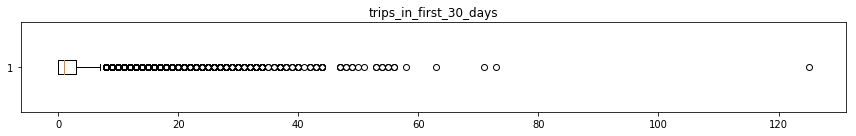

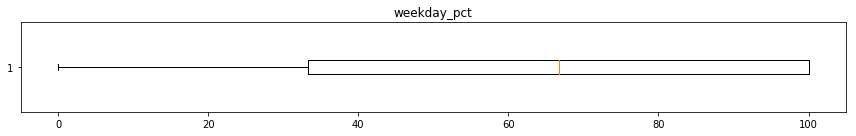

In [26]:
for c in cols_dict['cols_number_exclude_binary']:
    fig = plt.figure(figsize=(12,2))
    plt.boxplot(df0[c].dropna(), vert=False)
    plt.title(c)
    plt.tight_layout()
    plt.show()

### Visualization of Distributions

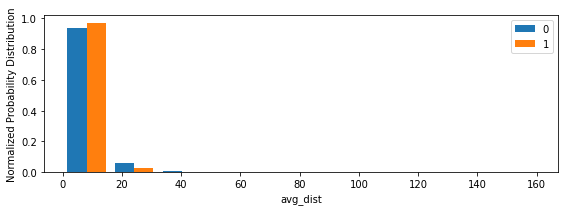

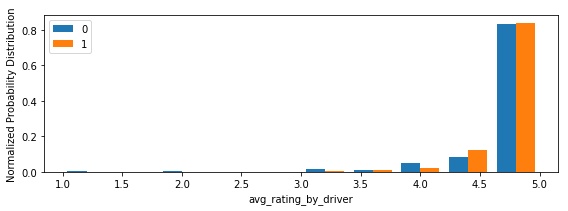

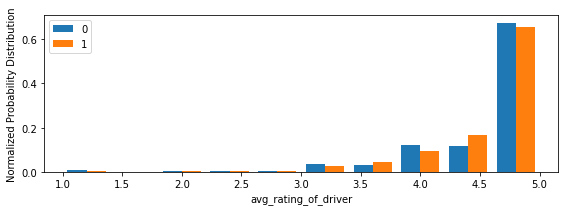

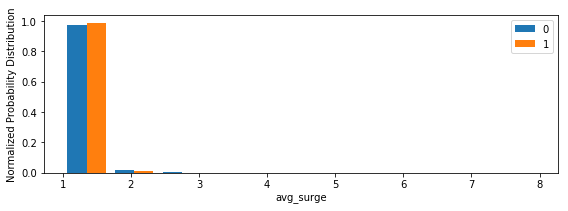

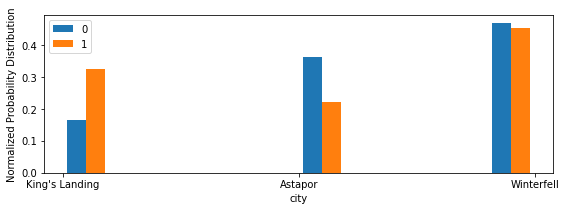

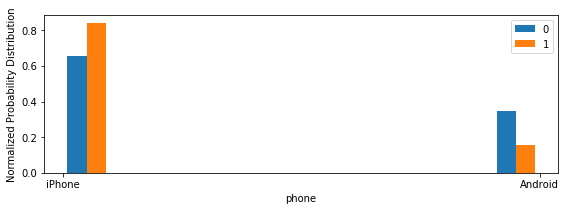

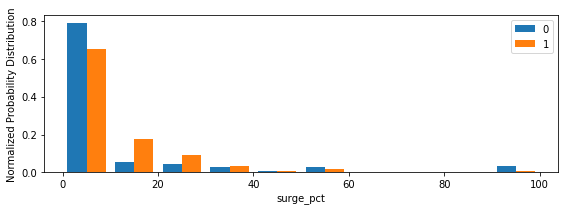

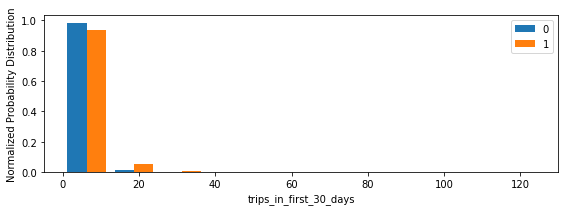

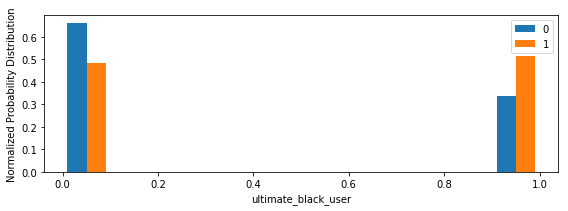

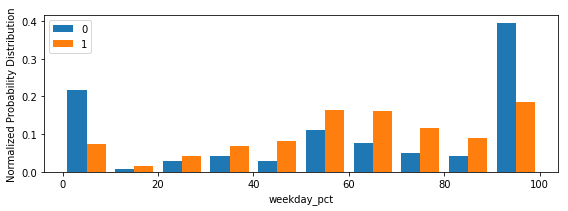

In [27]:
func_eda_hist_by_label_plot(df0.drop(columns=['active']), df0['active'], figsize=(8,3))

### Correlation Analysis 

#### Pearson Correlation (Numerical Features Only)

In [28]:
# pearson correlation 
df0.corr()['active'].sort_values(ascending=False)

active                    1.000000
trips_in_first_30_days    0.200563
ultimate_black_user       0.154334
surge_pct                 0.018170
avg_surge                 0.007247
weekday_pct               0.001407
avg_rating_of_driver     -0.007815
avg_rating_by_driver     -0.021244
avg_dist                 -0.089616
Name: active, dtype: float64

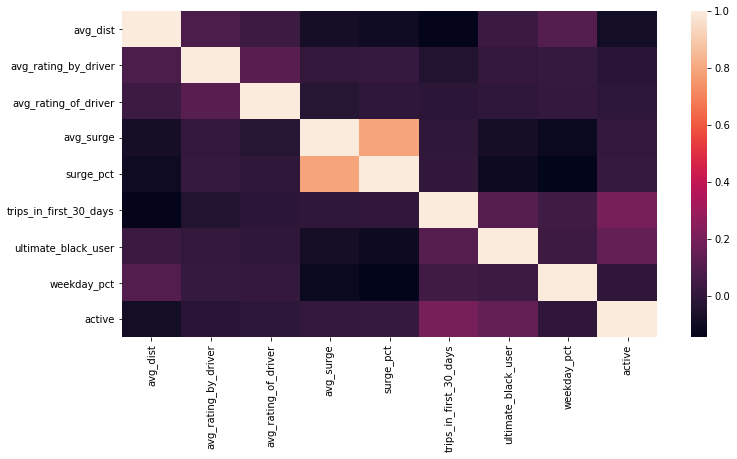

In [29]:
sns.heatmap(df0.corr())

#### Pair Plots (Numerical Features Only)

C:\Users\zb\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\zb\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\zb\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\zb\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


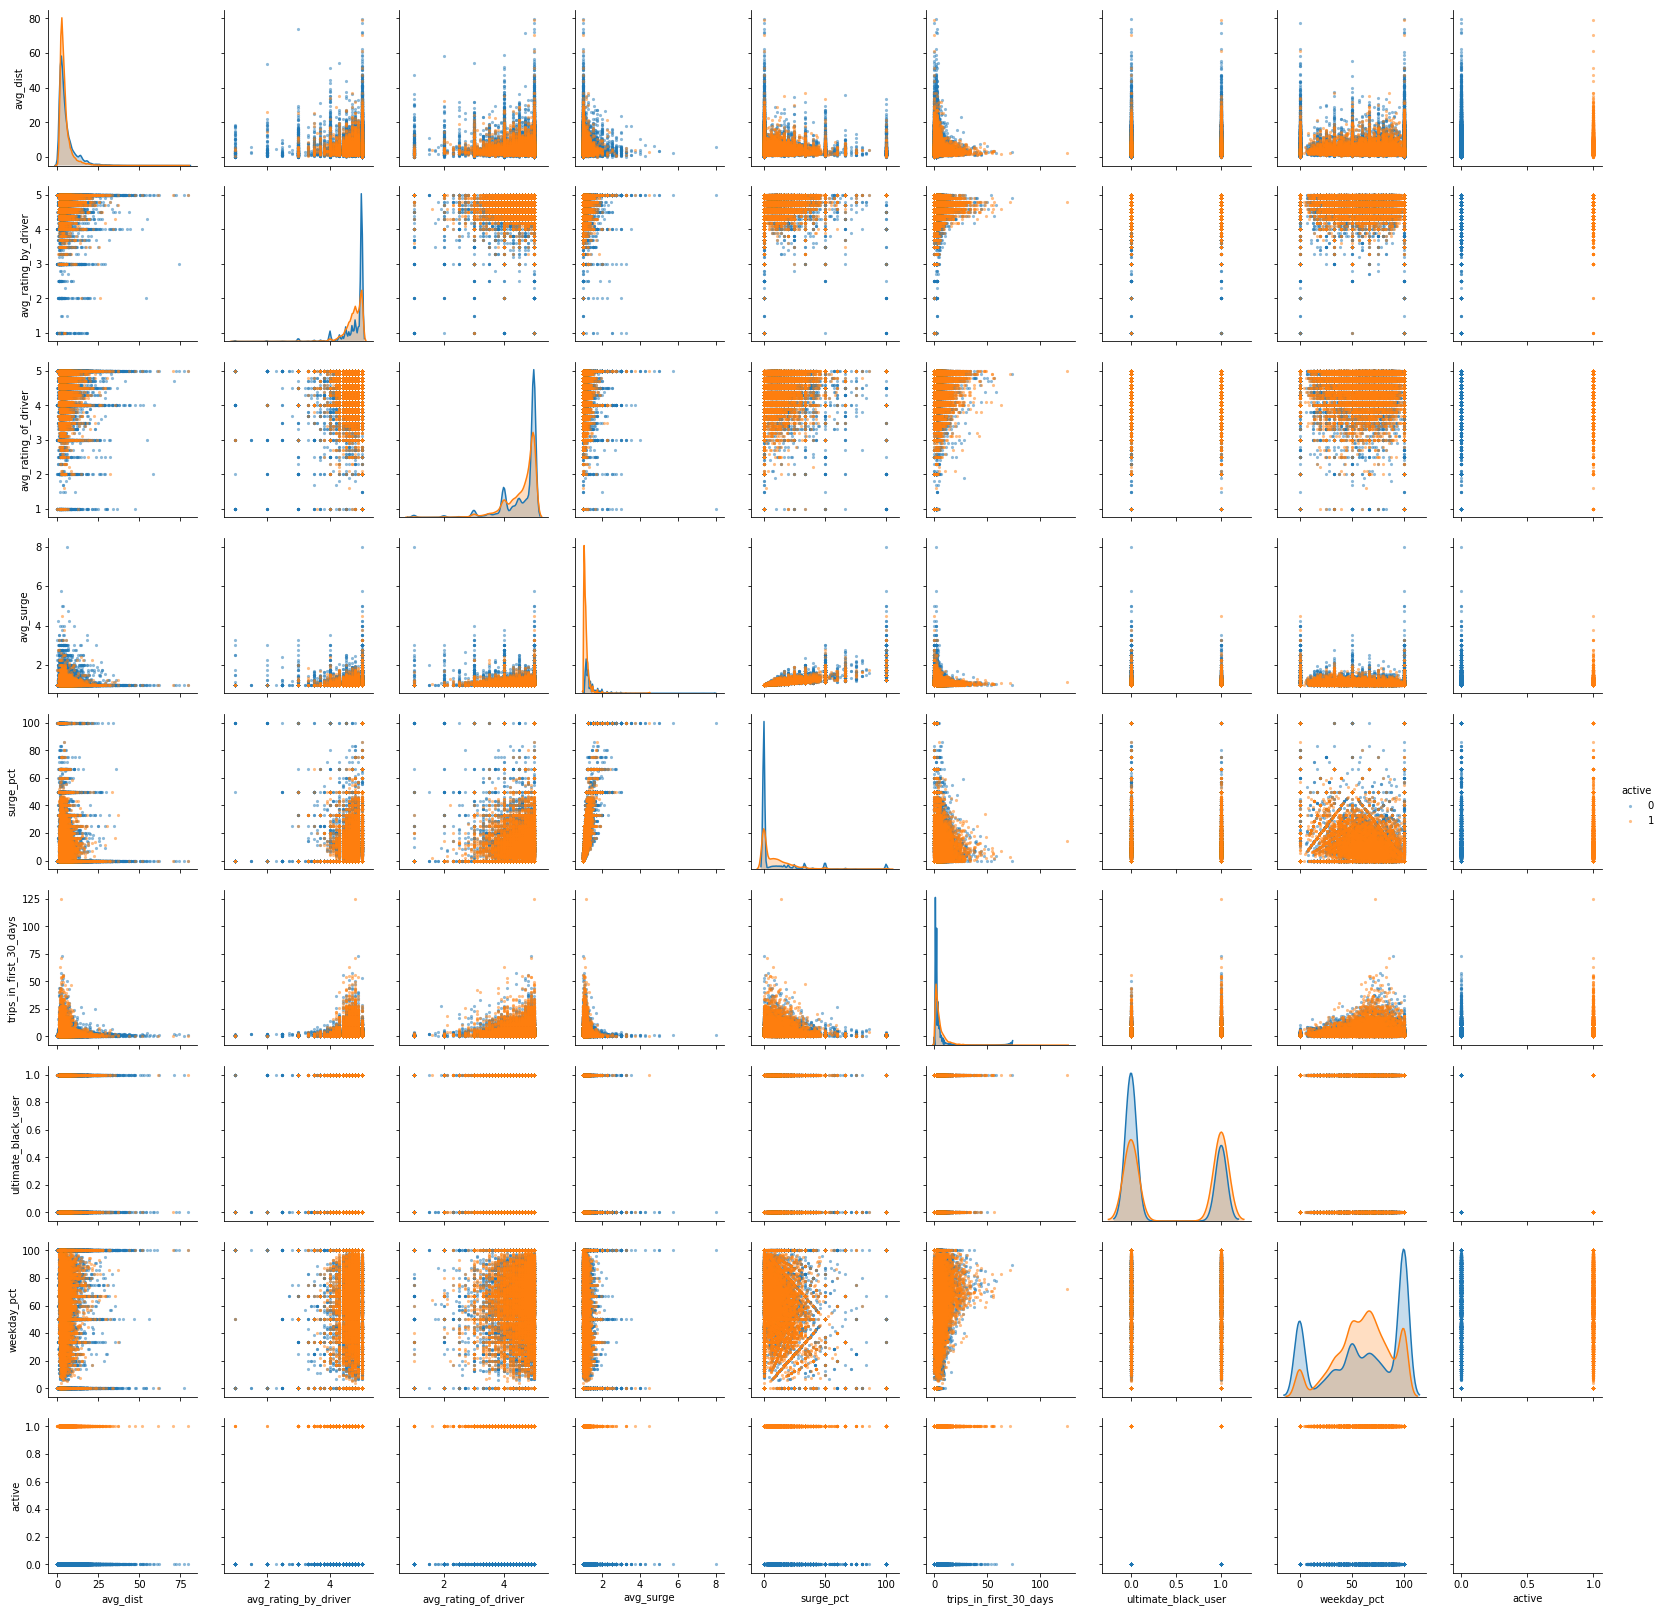

In [31]:
g = sns.pairplot(df0.dropna(), hue="active",plot_kws=dict(linewidth=0, alpha=0.5, s=10))

#### Cramers' V Test (For Categorical Features) 

For categorical and binary features, it is found that the `creation_timeMonth`, `ceation_source` and `email_domain` have relatively higher correlation with the label `adopted_user`. 

Note: Cramer’s V test measures the association betwwen two nominal features. It is an enhancement of the Chi-Square test (which provides result on whether it is a significant relationship between variables, without quantifying how significant and important it is). Cramer’s V varies between 0 and 1. Close to 0 it shows little association between variables. Close to 1, it indicates a strong association.

In [32]:
# features that are categorical
func_df_cramers_v(df0[cols_dict['cols_string_include_binary']], df0['active'])

,feature,cramers_v
0,city,0.063806
1,phone,0.060092
2,ultimate_black_user,0.054474


### Discussion

#### Discussion on Correlation Analysis

From the correlation results and distribution plots above, it shows that following fields are more important including:
* `city`: higher proportion of active driver in KingsLanding
* `phone`: higher proportion of active driver using Android Phone
* `trips_in_first_30_days`: active users in the first 30 days tends to remain active
* `ultimate_black_user`: drivers who took an Ultimate Black is more likely to remain active

## Model

### Train-Test Split

The dataset if imbalanced with 16.4% 'adopted_user'. Thus stratified train-test-split is implemented. 

In [10]:
# stratified split 70-30%
label_name = 'active'
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df0.drop(label_name,axis=1), df0[label_name],
                                                                test_size = 0.30, random_state = 42, 
                                                                stratify=df0[label_name])

print('Training dataframe shape:', df_X_train.shape)
print('Test dataframe Shape:', df_X_test.shape)
print('Label = 1 in training set = {:.2f}%'.format((df_y_train.sum()/df_y_train.shape[0]*100.0)))
print('Label = 0 in test set = {:.2f}%'.format((df_y_test.sum()/df_y_test.shape[0]*100.0)))


Training dataframe shape: (35000, 10)
Test dataframe Shape: (15000, 10)
Label = 1 in training set = 22.39%
Label = 0 in test set = 22.39%


In [11]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int32
weekday_pct               50000 non-null float64
active                    50000 non-null int64
dtypes: float64(6), int32(1), int64(2), object(2)
memory usage: 4.0+ MB


### Pre-Processing 

#### Training Data

In [12]:
scaler_standard = StandardScaler()
imp_median = SimpleImputer(strategy='median')
df_X_train[cols_dict['cols_number_exclude_binary']] = scaler_standard.fit_transform(df_X_train[cols_dict['cols_number_exclude_binary']])
df_X_train[cols_dict['cols_number_exclude_binary']] = imp_median.fit_transform(df_X_train[cols_dict['cols_number_exclude_binary']])

# one-hot encoding for categorical features
df_X_train = pd.get_dummies(df_X_train,columns=cols_dict['cols_string'],drop_first=True,dtype=float)
# record columns in final training data
col_train = df_X_train.columns.values

C:\Users\zb\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\zb\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [21]:
df_X_train.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,city_King's Landing,city_Winterfell,phone_iPhone
count,3.500000e+04,35000.000000,35000.000000,3.500000e+04,3.500000e+04,3.500000e+04,35000.000000,3.500000e+04,35000.000000,35000.000000,35000.000000
mean,-2.010773e-17,0.001949,0.078882,-2.893974e-15,4.098309e-18,5.292861e-16,0.378971,-2.015023e-16,0.203829,0.466914,0.691686
std,1.000014e+00,0.998521,0.932378,1.000014e+00,1.000014e+00,1.000014e+00,0.485138,1.000014e+00,0.402849,0.498911,0.461804
min,-1.014753e+00,-8.439856,-5.828887,-3.357995e-01,-4.443061e-01,-5.973221e-01,0.000000,-1.647431e+00,0.000000,0.000000,0.000000
25%,-5.924710e-01,-0.175814,-0.162767,-3.357995e-01,-4.443061e-01,-5.973221e-01,0.000000,-7.493374e-01,0.000000,0.000000,0.000000
50%,-3.348963e-01,0.494243,0.484789,-3.357995e-01,-4.443061e-01,-3.347893e-01,0.000000,1.514536e-01,0.000000,0.000000,1.000000
75%,1.995274e-01,0.494243,0.646678,-1.107208e-01,-1.256050e-02,1.902762e-01,1.000000,1.049548e+00,0.000000,1.000000,1.000000
max,2.718880e+01,0.494243,0.646678,3.117523e+01,4.575991e+00,3.221927e+01,1.000000,1.049548e+00,1.000000,1.000000,1.000000


#### Test Data

In [13]:
# apply the same preprocessing steps as training data
df_X_test[cols_dict['cols_number_exclude_binary']] = scaler_standard.transform(df_X_test[cols_dict['cols_number_exclude_binary']])
df_X_test[cols_dict['cols_number_exclude_binary']] = imp_median.transform(df_X_test[cols_dict['cols_number_exclude_binary']])
df_X_test = pd.get_dummies(df_X_test,columns=cols_dict['cols_string'],drop_first=True,dtype=float)
col_test = df_X_test.columns.values

# Get missing columns in the training test
missing_cols = set(col_train) - set(col_test)
# Add a missing column in test set with default value equal to 0 (i.e., indicating this level does not exists)
for c in missing_cols:
    df_X_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
df_X_test = df_X_test[col_train]

df_X_test.shape

C:\Users\zb\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


(15000, 11)

In [23]:
df_X_test.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,city_King's Landing,city_Winterfell,phone_iPhone
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,0.003239,-0.002061,0.083034,0.002518,-0.000110,0.002600,0.372667,-0.014226,0.199733,0.466267,0.691533
std,1.000157,0.990435,0.930593,1.002870,1.006624,0.985604,0.483531,1.000197,0.399813,0.498877,0.461876
min,-1.014753,-8.439856,-5.828887,-0.335800,-0.444306,-0.597322,0.000000,-1.647431,0.000000,0.000000,0.000000
25%,-0.585462,-0.175814,-0.162767,-0.335800,-0.444306,-0.597322,0.000000,-0.749337,0.000000,0.000000,0.000000
50%,-0.331392,0.494243,0.484789,-0.335800,-0.444306,-0.334789,0.000000,0.151454,0.000000,0.000000,1.000000
75%,0.203032,0.494243,0.646678,-0.110721,-0.016326,0.190276,1.000000,1.049548,0.000000,1.000000,1.000000
max,12.948599,0.494243,0.646678,16.545109,4.575991,18.567570,1.000000,1.049548,1.000000,1.000000,1.000000


#### Upsampling

Due to the imbalanced dataset, it might be worth to try upsampling. 

In [14]:
from imblearn.over_sampling import SMOTE
X_upsampled, y_upsampled = SMOTE().fit_resample(df_X_train, df_y_train)

In [25]:
print('Training dataframe shape:', X_upsampled.shape)
print('Test dataframe Shape:', y_upsampled.shape)
print('Label = 1 in upsampled training set = {:.2f}%'.format((y_upsampled.sum()/y_upsampled.shape[0]*100.0)))

Training dataframe shape: (54328, 11)
Test dataframe Shape: (54328,)
Label = 1 in upsampled training set = 50.00%


### Model Selection using Cross-Validation

Several machine learning classifiers are compared with their default hyper-parameters. For decision tree based models (e.g. GradientBoosting, RandomForest and XGBoost), 100 trees/estimators are adopted for a fair comparison. 

#### Original Imbalanced Dataset

In [131]:
models_fitted =[]  # record models
models_fitted_names = []  # record model names 

# define 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
models = [GaussianNB(),
          LogisticRegression(random_state=42, verbose=0, n_jobs=-1, solver='lbfgs'), 
          RandomForestClassifier(n_estimators=100, random_state=42, verbose=0, n_jobs=-1),
          GradientBoostingClassifier(n_estimators=100, random_state=42, verbose=0),
          XGBClassifier(n_estimators=100, random_state=42, verbose=0, n_jobs=-1)
         ]
names = ["NaiveBayes","Logistic","RandomForest","GradientBoosting","XGBoosting"]

df_scores = pd.DataFrame()

for model, name in zip(models, names):
    print("Executing {} model.".format(name))
    scoring = {'acc': 'accuracy',
               'prec': 'precision',
               'rec': 'recall',
               'f1': 'f1', 
               'roc_auc': 'roc_auc'}
    
    # original dataset
    score = cross_validate(model, df_X_train.values, df_y_train.values, scoring=scoring,
                           cv=cv, return_train_score=False)
    df_score = pd.DataFrame(score)
    df_score.index = df_score.index.set_names(['cv'])
    df_score.reset_index(inplace=True)
    df_score.insert(loc=0, column='Name', value=name)
    df_scores = pd.concat([df_scores, df_score])
    models_fitted.append(model.fit(df_X_train.values, df_y_train.values))
    models_fitted_names.append(name)
    
    # upsampled dataset
    score = cross_validate(model, X_upsampled, y_upsampled, scoring=scoring,
                           cv=cv, return_train_score=False)
    df_score = pd.DataFrame(score)
    df_score.index = df_score.index.set_names(['cv'])
    df_score.reset_index(inplace=True)
    df_score.insert(loc=0, column='Name', value=name+'_upsampled')
    df_scores = pd.concat([df_scores, df_score])
    models_fitted.append(model.fit(X_upsampled, y_upsampled))
    models_fitted_names.append(name+'_upsampled')


Executing NaiveBayes model.
Executing Logistic model.
Executing RandomForest model.
Executing GradientBoosting model.
Executing XGBoosting model.


In [132]:
df_scores[['Name','test_prec','test_rec','test_f1','test_roc_auc']].groupby('Name').agg(['mean','std'])

test_prec            test_rec             test_f1  \
                                mean       std      mean       std      mean   
Name                                                                           
GradientBoosting            0.620069  0.015241  0.348901  0.012391  0.446497   
GradientBoosting_upsampled  0.821086  0.006297  0.830069  0.003430  0.825548   
Logistic                    0.574042  0.009571  0.140122  0.010267  0.225066   
Logistic_upsampled          0.676232  0.005497  0.662310  0.006122  0.669181   
NaiveBayes                  0.465470  0.010263  0.504720  0.018825  0.484180   
NaiveBayes_upsampled        0.640817  0.003969  0.781512  0.005996  0.704193   
RandomForest                0.517056  0.007934  0.374043  0.013527  0.433969   
RandomForest_upsampled      0.837345  0.005063  0.871632  0.002714  0.854138   
XGBoosting                  0.624840  0.014223  0.345456  0.011211  0.444896   
XGBoosting_upsampled        0.817657  0.005438  0.833051  0.004298  0.825277   

                                     test_roc_auc            
                                 std         mean       std  
Name                                                         
GradientBoosting            0.013387     0.815460  0.005507  
GradientBoosting_upsampled  0.004546     0.908057  0.002925  
Logistic                    0.013139     0.730490  0.007327  
Logistic_upsampled          0.004361     0.733679  0.006139  
NaiveBayes                  0.011997     0.742230  0.009496  
NaiveBayes_upsampled        0.003530     0.747227  0.005853  
RandomForest                0.010230     0.777271  0.003556  
RandomForest_upsampled      0.003192     0.927201  0.003268  
XGBoosting                  0.012431     0.815398  0.005316  
XGBoosting_upsampled        0.004318     0.908294  0.002585

### Model Evaluation based on Fixed Validation Set

The summary of F1-score above suggests RandomForest might be the right candidate for final model. Although model trained with upsampled data is performs better in general in terms of F1-score, the usefulness of upsampling on model performance is further examined with a fixed validadtion set. 

In [133]:
df_scores_vali = pd.DataFrame()

for model, name in zip(models_fitted, models_fitted_names):
    print("Executing {} model.".format(name))
    scoring = {'acc': 'accuracy',
               'prec': 'precision',
               'rec': 'recall',
               'f1': 'f1', 
               'roc_auc': 'roc_auc'}    
    y_pred_test = model.predict(df_X_test.values)
    #print("Test accuracy = {:.6f}".format(accuracy_score(df_y_test.values, y_pred_test)))
    unique_label = np.unique(df_y_test.values)
    cm = confusion_matrix(df_y_test.values, y_pred_test, labels=unique_label)
    cr = classification_report(df_y_test.values, y_pred_test, output_dict=True)
    df_score = pd.DataFrame(cr)
    df_score.index = df_score.index.set_names(['metric'])
    df_score.reset_index(inplace=True)
    df_score.insert(loc=0, column='Name', value=name)
    df_scores_vali = pd.concat([df_scores_vali, df_score])

Executing NaiveBayes model.
Executing NaiveBayes_upsampled model.
Executing Logistic model.
Executing Logistic_upsampled model.
Executing RandomForest model.
Executing RandomForest_upsampled model.
Executing GradientBoosting model.
Executing GradientBoosting_upsampled model.
Executing XGBoosting model.
Executing XGBoosting_upsampled model.


In [134]:
df_scores_vali[df_scores_vali["metric"]=="f1-score"]#.sort_values('1')

,Name,metric,0,1,micro avg,macro avg,weighted avg
0,NaiveBayes,f1-score,0.686613,0.462485,0.604067,0.574549,0.636438
0,NaiveBayes_upsampled,f1-score,0.686613,0.462485,0.604067,0.574549,0.636438
0,Logistic,f1-score,0.766364,0.469870,0.675667,0.618117,0.699989
0,Logistic_upsampled,f1-score,0.766364,0.469870,0.675667,0.618117,0.699989
0,RandomForest,f1-score,0.848277,0.497557,0.766933,0.672917,0.769762
0,RandomForest_upsampled,f1-score,0.848277,0.497557,0.766933,0.672917,0.769762
0,GradientBoosting,f1-score,0.848885,0.553034,0.774133,0.700960,0.782654
0,GradientBoosting_upsampled,f1-score,0.848885,0.553034,0.774133,0.700960,0.782654
0,XGBoosting,f1-score,0.847037,0.549875,0.771667,0.698456,0.780512
0,XGBoosting_upsampled,f1-score,0.847037,0.549875,0.771667,0.698456,0.780512


### Discussion

F1 score for label 1 is used to balance the impact from precision and recall.

Noted that during model selection, model trained with original imbalanced dataset generally result in lower F1 score, which is due to the skewness in the dataset. As it’s shown in the above cross-validation set, the F1 score droped significantly when testing on an imbalanced validation dataset.

From the performance on the validation dataset, it shows that Gradient Boosting classifier provides the highest F1 score, 0.553. The following part will further optimize the model and evaluate the feature importance.

## Final Model

### Grid Search

THe dictionary below shows the hyperparameters under GradientBoosting model. Here, we will perform randomized search on `learning_rate`, `max_features` and `max_depth` using a subset of data (5000 samples). 

In [37]:
## hyper-parameters that can be tuned 

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 3)]

# Learnign Rate
learning_rate = [1e-2, 1e-1, 1.]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 9, num = 3)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
subsample = [0.2, 0.5, 1.0]

random_grid = {
#     'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'max_features': max_features,
    'max_depth': max_depth,
#     'min_samples_split': min_samples_split,
#     'min_samples_leaf': min_samples_leaf,
#     'subsample': subsample
}

In [38]:
clf_base = GradientBoostingClassifier(verbose=1, random_state=42)
kf = StratifiedKFold(n_splits=5)

clf_rs = RandomizedSearchCV(estimator = clf_base, 
                            param_distributions = random_grid, 
                            scoring='f1',
                            n_iter = 30, 
                            cv = kf, 
                            verbose=0, 
                            random_state=42, 
                            n_jobs = 2)

clf_rs.fit(df_X_train.values[:5000,], df_y_train.values[:5000,])

      Iter       Train Loss   Remaining Time 
         1           1.0409            0.30s
         2           1.0131            0.54s
         3           0.9894            0.65s
         4           0.9693            0.74s
         5           0.9512            0.84s
         6           0.9341            0.89s
         7           0.9204            0.88s
         8           0.9070            0.91s
         9           0.8952            0.93s
        10           0.8855            0.87s
        20           0.8179            0.60s
        30           0.7817            0.45s
        40           0.7544            0.35s
        50           0.7333            0.28s
        60           0.7133            0.21s
        70           0.6955            0.15s
        80           0.6794            0.10s
        90           0.6617            0.05s
       100           0.6431            0.00s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
          error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=1, warm_start=False),
          fit_params=None, iid='warn', n_iter=30, n_jobs=2,
          param_distributions={'learning_rate': [0.01, 0.1, 1.0], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [1, 5, 9, None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [39]:
print("Best parameters set found on development set:")
print(clf_rs.best_estimator_)

with open('./clf_gs.pickle', 'wb') as handle:
    pickle.dump(clf_rs, handle, protocol=pickle.HIGHEST_PROTOCOL)

Best parameters set found on development set:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=1, warm_start=False)


### Performance (F1-Score) and Feature Importance of Final Model

In [40]:
clf_rs_best = clf_rs.best_estimator_
scoring = {'acc': 'accuracy',
           'prec': 'precision',
           'rec': 'recall',
           'f1': 'f1', 
           'roc_auc': 'roc_auc'}  
clf_rs_best.fit(df_X_train.values,df_y_train.values)  # model fitting
y_pred_test = clf_rs_best.predict(df_X_test.values)  # prediction

unique_label = np.unique(df_y_test.values)  # get test label 0 and 1
cm = confusion_matrix(df_y_test.values, y_pred_test, labels=unique_label)  # calculate confusion matrix
cr = classification_report(df_y_test.values, y_pred_test, output_dict=True)

print(pd.DataFrame(cm, 
                   index=['true:{:}'.format(x) for x in unique_label],
                   columns=['pred:{:}'.format(x) for x in unique_label]))

df_score = pd.DataFrame(cr)
display(df_score)

      Iter       Train Loss   Remaining Time 
         1           1.0322            1.98s
         2           1.0063            2.40s
         3           0.9860            2.59s
         4           0.9672            2.62s
         5           0.9518            2.60s
         6           0.9358            2.57s
         7           0.9242            2.51s
         8           0.9130            2.48s
         9           0.9035            2.62s
        10           0.8946            2.68s
        20           0.8468            2.02s
        30           0.8278            1.59s
        40           0.8171            1.29s
        50           0.8088            1.04s
        60           0.8024            0.80s
        70           0.7962            0.59s
        80           0.7903            0.39s
        90           0.7851            0.19s
       100           0.7808            0.00s
        pred:0  pred:1
true:0   10901     741
true:1    2142    1216


,0,1,micro avg,macro avg,weighted avg
f1-score,0.883208,0.457573,0.8078,0.670391,0.787923
precision,0.835774,0.621359,0.8078,0.728567,0.787774
recall,0.936351,0.362120,0.8078,0.649236,0.807800
support,11642.000000,3358.000000,15000.0000,15000.000000,15000.000000


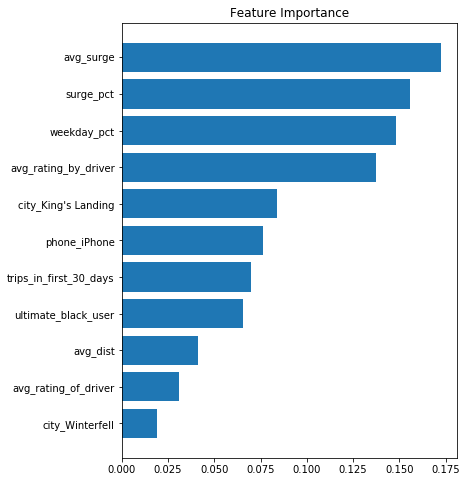

In [41]:
indices = np.argsort(clf_rs_best.feature_importances_)
plt.figure(figsize=[6,8])
plt.barh(col_train[indices], clf_rs_best.feature_importances_[indices])
plt.title('Feature Importance')
plt.show()

### Other Performance Metrics

#### ROC-AUC

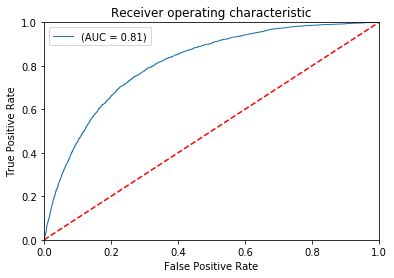

In [42]:
from sklearn.metrics import roc_curve, auc
probas_ = clf_rf_rs_best.predict_proba(df_X_test.values)
fpr, tpr, thresholds = roc_curve(df_y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=1.0, label='(AUC = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend()
plt.show()

#### Precision-Recall Curve

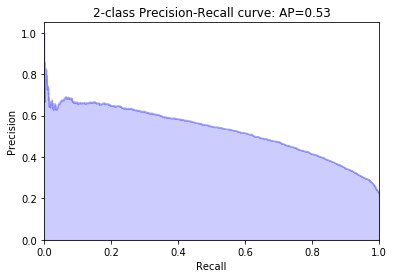

In [43]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from inspect import signature
precision, recall, thresholds = precision_recall_curve(df_y_test, probas_[:, 1])
average_precision = average_precision_score(df_y_test, probas_[:, 1])
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()


### Discussion

Feature Importance: 
* The feature importance indicates the top five features are: `avg_surge`, `surge_pct`, `weekday_pct`, `avg_rating_by_driver`, and `city_Kings_Landing`, which does not agree with the analysis based on linear correlation and suggest nonlinear relationship among the features. 

Model Performance: 
* The F1-score of the final Gradient Boosting model is 0.458; ROC-AUC = 0.81; and Average Precision (AP) = 0.53;
* As the dataset is imbalanced (with 22% positive cases), F1-score and AP are more representative of the model performance;
* The model performance is moderate with relatively low precision (i.e. high False Positive). We could further improve the model performance by tuning the hyperparameters. 

Business Insights: 
* Drivers appear to be more motivated by 'surge' price;
* Regular drivers who also work on weekdays are more likely to remain positive;
* Drivers who rate highly (meaning more satisfied with their jobs) are more likely to remain positive;
* Drivers in King's Landing are generally more active than other cities. 

Business Action: it will be worth for Ultimate to
* Optimize the 'surge' price, so that it could bring more benefit to the drivers without hurting their customers;
* Give more incentives for drivers to take up jobs during weekdays;
* Conduct survey on drivers and get their feedbacks on what they like and dislike about Ultimate's system. 



**END**